# ******Scenario 2: Market research for new store locations******

A liquor store owner in Iowa is looking to expand to new locations and has hired you to investigate the market data for potential new locations. The business owner is interested in the details of the best model you can fit to the data so that his team can evaluate potential locations for a new storefront.

# Goal for Scenario #2: Your task is to:

* Build models of total sales based on location, price per bottle, total bottles sold. You may find it useful to build models for each county, zip code, or city.

* Provide a table of the best performing stores by location type of your choice (city, county, or zip code) and the predictions of your model(s)

* Based on your models and the table of data, recommend some general locations to the business owner, taking into account model performance

* Bonus: Recommend targets for volume sold and price per bottle!

In [535]:
import numpy as np
import scipy.stats as stats
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 10, 10

import seaborn as sns
from sklearn import linear_model


%matplotlib inline

# Import Data

In [569]:
# liquor_data = pd.read_csv("../../projects/project-03/Iowa_Liquor_sales_sample_10pct.csv")
liquor_data = pd.read_csv("../../projects/project-03/Iowa_Liquor_sales_reduced.csv")

liquor_df1 = pd.DataFrame(liquor_data)

//anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2902: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Data Cleaning

In [570]:
# Rename columns
liquor_df1.rename(columns ={"Bottle Volume (ml)": "Bottle Volume ml", 
                    "Sale (Dollars)": "Sale Dollars", 
                    "Volume Sold (Liters)": "Volume Sold Liters", 
                    "Volume Sold (Gallons)": "Volume Sold Gallons"}, inplace=True)

# Removing $ signs
dollarsigns = ['State Bottle Cost','State Bottle Retail','Sale Dollars']
liquor_df1[dollarsigns] = liquor_df1[dollarsigns].replace("\$","",regex=True).astype(float)

# format dates to datetime
liquor_df1['Date'] = pd.to_datetime(liquor_df1['Date'], format="%m/%d/%Y")

# drop NaNs
liquor_df2 = liquor_df.dropna()

liquor_df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 269258 entries, 0 to 270954
Data columns (total 18 columns):
Date                   269258 non-null datetime64[ns]
Store Number           269258 non-null int64
City                   269258 non-null object
Zip Code               269258 non-null object
County Number          269258 non-null float64
County                 269258 non-null object
Category               269258 non-null float64
Category Name          269258 non-null object
Vendor Number          269258 non-null int64
Item Number            269258 non-null int64
Item Description       269258 non-null object
Bottle Volume ml       269258 non-null int64
State Bottle Cost      269258 non-null float64
State Bottle Retail    269258 non-null float64
Bottles Sold           269258 non-null int64
Sale Dollars           269258 non-null float64
Volume Sold Liters     269258 non-null float64
Volume Sold Gallons    269258 non-null float64
dtypes: datetime64[ns](1), float64(7), int64(5), ob

# Data Dictionary

|Variables|description|
|----------|-----------|
|Date| Day of which sale occured |
|Store Number | Classifies each store |
|City | City location of store |
|Zip Code | Zip Code location of store |
|County Number | ID number of county |
|County | Name of county |
|Category | ID number of category of liquor |
|Category Name | Name of the type of liquor sold |
|Vendor Number| ID number of company that sold liquor to store|
|Item Number| ID number of the item sold
|Bottle Volume ml| Amount of liquid in a bottle in milliliters|
|State Bottle Cost| Cost of liquor to a store |
|State Bottle Retail| Price at which liquor was sold at the store|
|Bottles Sold| Amount of bottles sold|
|Sale Dollars| Total sales|
|Volume Sold Liters| Amount of liquid sold in liters|
|Volume Sold Gallons|Amount of liquid sold in Gallons|

# Problem Statement

There is a liquor store owner who is looking to expand to more locations in Iowa. We need to determine which locations would be the best to expand and determine potential sales of those areas. 

Goals:
* Clean data
* Calculate Margin, Price per Liter, Sales mean and totals
* Determine 
* Project future sales of counties
* Visualize projected future sales

In [571]:
# Calculate Margin and add to dataframe
liquor_df2["Margin"] = (liquor_df2["State Bottle Retail"] - liquor_df2["State Bottle Cost"]) * liquor_df2["Bottles Sold"]

# Calcualte Price per Liter and add to dataframe
liquor_df2['Price per Liter'] = liquor_df2['Sale Dollars'] / liquor_df2['Volume Sold Liters']


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# Delete redundant columns

In [572]:
del liquor_df2['County']
del liquor_df2['Item Description']
del liquor_df2['Category Name']
del liquor_df2['Volume Sold Gallons']

liquor_df2['Category'] = liquor_df2['Category'].astype(int)
liquor_df2['County Number'] = liquor_df2['County Number'].astype(int)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [573]:
liquor_df2

,Date,Store Number,City,Zip Code,County Number,Category,Vendor Number,Item Number,Bottle Volume ml,State Bottle Cost,State Bottle Retail,Bottles Sold,Sale Dollars,Volume Sold Liters,Margin,Price per Liter
0,2015-11-04,3717,SUMNER,50674,9,1051100,55,54436,750,4.50,6.75,12,81.00,9.00,27.00,9.000000
1,2016-03-02,2614,DAVENPORT,52807,82,1011100,395,27605,750,13.75,20.63,2,41.26,1.50,13.76,27.506667
2,2016-02-11,2106,CEDAR FALLS,50613,7,1011200,65,19067,1000,12.59,18.89,24,453.36,24.00,151.20,18.890000
3,2016-02-03,2501,AMES,50010,85,1071100,395,59154,1750,9.50,14.25,6,85.50,10.50,28.50,8.142857
4,2015-08-18,3654,BELMOND,50421,99,1031080,297,35918,1750,7.20,10.80,12,129.60,21.00,43.20,6.171429
5,2015-04-20,2569,CEDAR RAPIDS,52402,57,1041100,205,31473,1750,13.32,19.98,6,119.88,10.50,39.96,11.417143
6,2015-08-05,2596,OTTUMWA,52501,90,1051010,85,52806,750,6.66,9.99,3,29.97,2.25,9.99,13.320000
7,2015-06-25,3456,CLEAR LAKE,50428,17,1012100,65,10628,1750,15.75,23.63,2,47.26,3.50,15.76,13.502857
8,2016-01-04,4757,BONDURANT,50035,77,1032080,370,34006,750,11.49,17.24,4,68.96,3.00,23.00,22.986667
9,2015-11-10,4346,SHELLSBURG,52332,6,1081315,65,82610,1000,7.62,11.43,2,22.86,2.00,7.62,11.430000


In [574]:
liquor_df2.corr()

,Store Number,County Number,Category,Vendor Number,Item Number,Bottle Volume ml,State Bottle Cost,State Bottle Retail,Bottles Sold,Sale Dollars,Volume Sold Liters,Margin,Price per Liter
Store Number,1.000000,0.007724,-0.012263,-0.005079,-0.026459,-0.062526,-0.071294,-0.071430,0.014662,-0.017750,-0.017375,-0.017692,-0.014338
County Number,0.007724,1.000000,-0.006303,0.001717,0.006898,-0.027864,0.012032,0.011958,0.018950,0.019775,0.010185,0.019546,0.031256
Category,-0.012263,-0.006303,1.000000,0.091512,0.116619,-0.009055,-0.013571,-0.013758,-0.000080,0.006542,-0.004192,0.006182,-0.019517
Vendor Number,-0.005079,0.001717,0.091512,1.000000,0.136183,0.025909,0.003616,0.003223,-0.002303,-0.012361,-0.007254,-0.012795,0.011031
Item Number,-0.026459,0.006898,0.116619,0.136183,1.000000,-0.057681,0.096084,0.095815,-0.005021,0.002372,-0.010010,0.002016,0.159695
Bottle Volume ml,-0.062526,-0.027864,-0.009055,0.025909,-0.057681,1.000000,0.312930,0.313911,-0.012183,0.082553,0.156141,0.082977,-0.305618
State Bottle Cost,-0.071294,0.012032,-0.013571,0.003616,0.096084,0.312930,1.000000,0.999960,-0.062832,0.135770,0.009301,0.134701,0.734026
State Bottle Retail,-0.071430,0.011958,-0.013758,0.003223,0.095815,0.313911,0.999960,1.000000,-0.062684,0.135954,0.009742,0.134927,0.733581
Bottles Sold,0.014662,0.018950,-0.000080,-0.002303,-0.005021,-0.012183,-0.062832,-0.062684,1.000000,0.825912,0.883972,0.827511,-0.061718
Sale Dollars,-0.017750,0.019775,0.006542,-0.012361,0.002372,0.082553,0.135770,0.135954,0.825912,1.000000,0.846373,0.999799,0.063208


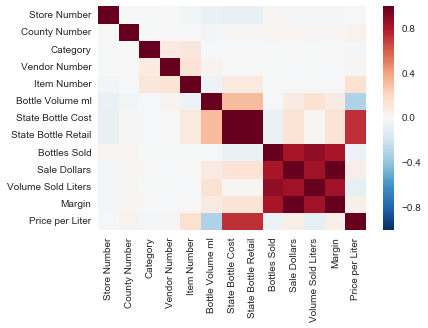

In [575]:
sns.heatmap(liquor_df2.corr())

In [576]:
top_county = liquor_df2[["County Number",'Sale Dollars']].groupby('County Number').sum().reset_index().sort('Sale Dollars', ascending=False).head(10)
top_county

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,County Number,Sale Dollars
76,77,7.747219e+06
56,57,3.139999e+06
81,82,2.457277e+06
51,52,2.077858e+06
6,7,1.928017e+06
77,78,1.277581e+06
96,97,1.249514e+06
30,31,1.076389e+06
84,85,1.073666e+06
16,17,6.949539e+05


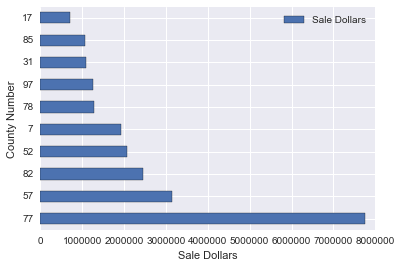

In [607]:
fig = plt.figure(figsize=(10,8))

top_county.plot(kind='barh',x='County Number', y='Sale Dollars')
plt.xlabel('Sale Dollars')
plt.ylabel('County Number')

In [578]:
# Grouping the dataframe into 2015 and 2016

mask2015 = (liquor_df2["Date"] >= "20150101") & (liquor_df2["Date"] <= "20151231")
mask2016 = liquor_df2[liquor_df2["Date"] >= "20160101"]

In [579]:
# Create a new dataframe for 2015
sales2015 = liquor_df2[mask2015]

In [580]:
# Group dataframe by County
sales2015 = sales2015.groupby(by="County Number")

In [581]:
# Rename find the mean of metrics

sales2015 = sales2015.agg({"Sale Dollars": [np.sum, np.mean],
                          "Volume Sold Liters": [np.sum, np.mean],
                          "Margin": np.mean,
                          "Price per Liter": np.mean})

# Join the columns 

sales2015.columns = [' '.join(col) for col in sales2015.columns.values]

In [582]:
# Reset the index

sales2015 = sales2015.reset_index()

In [583]:
# Rename the columns appropriately

sales2015.columns = ['County Number', '2015 Price per Liter mean',
                    '2015 Margin mean', '2015 Volume Sold Liters sum',
                    '2015 Volume Sold Liters mean', '2015 Sale Dollars sum',
                    '2015 Sale Dollars mean']

sales2015.head(2)

,County Number,2015 Price per Liter mean,2015 Margin mean,2015 Volume Sold Liters sum,2015 Volume Sold Liters mean,2015 Sale Dollars sum,2015 Sale Dollars mean
0,1,15.370692,30.976462,3510.22,7.436907,43747.18,92.684703
1,2,17.324104,18.082910,822.28,4.350688,10245.14,54.207090


In [584]:
sales2015.corr()

,County Number,2015 Price per Liter mean,2015 Margin mean,2015 Volume Sold Liters sum,2015 Volume Sold Liters mean,2015 Sale Dollars sum,2015 Sale Dollars mean
County Number,1.000000,0.106470,0.046447,0.116524,0.013705,0.119101,0.047180
2015 Price per Liter mean,0.106470,1.000000,0.439169,0.484202,0.213184,0.481044,0.442177
2015 Margin mean,0.046447,0.439169,1.000000,0.400735,0.938437,0.397468,0.999948
2015 Volume Sold Liters sum,0.116524,0.484202,0.400735,1.000000,0.264726,0.999247,0.403998
2015 Volume Sold Liters mean,0.013705,0.213184,0.938437,0.264726,1.000000,0.258125,0.936030
2015 Sale Dollars sum,0.119101,0.481044,0.397468,0.999247,0.258125,1.000000,0.400776
2015 Sale Dollars mean,0.047180,0.442177,0.999948,0.403998,0.936030,0.400776,1.000000


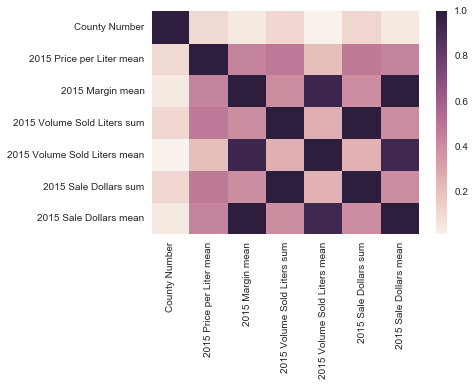

In [585]:
sns.heatmap(sales2015.corr())

In [586]:
# sales2015 = sales2015.reset_index()
top_county_sales = sales2015.sort("2015 Volume Sold Liters sum", ascending=False).head(10)
top_county_sales

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


,County Number,2015 Price per Liter mean,2015 Margin mean,2015 Volume Sold Liters sum,2015 Volume Sold Liters mean,2015 Sale Dollars sum,2015 Sale Dollars mean
76,77,19.610864,54.002390,413559.44,10.465355,6386721.54,161.619595
56,57,18.574054,45.341375,181566.09,9.472849,2600504.00,135.676110
81,82,19.105963,50.877102,133285.10,9.948877,2041085.70,152.353937
6,7,18.629243,43.642106,108665.93,8.973981,1581180.31,130.578934
51,52,19.296249,53.665110,105822.94,9.893693,1718425.51,160.660575
77,78,17.576329,46.026174,69062.53,9.397541,1012796.75,137.814226
96,97,18.454202,48.150292,67461.05,9.719212,1000327.36,144.118623
30,31,17.596350,47.327857,65343.68,10.416656,886520.97,141.323286
84,85,18.676490,41.131370,61609.05,8.541391,887234.71,123.004951
16,17,17.295056,36.882009,42973.60,8.307288,569900.98,110.168370


In [587]:
# sns.barplot(x='County Number', y='2015 Volume Sold Liters sum', data=sales2015)

In [588]:
sales2015.sort("2015 Sale Dollars mean", ascending=False).head(10)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,County Number,2015 Price per Liter mean,2015 Margin mean,2015 Volume Sold Liters sum,2015 Volume Sold Liters mean,2015 Sale Dollars sum,2015 Sale Dollars mean
24,25,17.957090,76.448614,30011.90,13.679079,500766.01,228.243396
13,14,16.924952,56.580821,20081.95,12.582675,268966.50,168.525376
82,83,16.396670,56.393782,7784.10,14.152909,92196.85,167.630636
76,77,19.610864,54.002390,413559.44,10.465355,6386721.54,161.619595
51,52,19.296249,53.665110,105822.94,9.893693,1718425.51,160.660575
44,45,16.376934,53.291799,7120.60,13.485985,83572.98,158.282159
81,82,19.105963,50.877102,133285.10,9.948877,2041085.70,152.353937
33,34,16.844332,50.045899,9150.70,11.269335,121284.60,149.365271
83,84,16.790471,49.394051,11473.85,10.733255,157514.32,147.347353
93,94,17.652243,48.685233,26985.55,10.855008,360628.42,145.063725


In [589]:
sales2015.sort("2015 Price per Liter mean", ascending=False).head(10)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,County Number,2015 Price per Liter mean,2015 Margin mean,2015 Volume Sold Liters sum,2015 Volume Sold Liters mean,2015 Sale Dollars sum,2015 Sale Dollars mean
76,77,19.610864,54.002390,413559.44,10.465355,6386721.54,161.619595
51,52,19.296249,53.665110,105822.94,9.893693,1718425.51,160.660575
50,51,19.107775,42.852458,5474.78,8.409800,83560.91,128.357773
81,82,19.105963,50.877102,133285.10,9.948877,2041085.70,152.353937
10,11,18.756353,26.933776,11778.94,5.470943,173439.66,80.557204
28,29,18.682759,39.183328,25767.62,7.824968,385621.77,117.103483
84,85,18.676490,41.131370,61609.05,8.541391,887234.71,123.004951
91,92,18.667469,38.296159,9725.73,7.749586,143907.46,114.667299
6,7,18.629243,43.642106,108665.93,8.973981,1581180.31,130.578934
56,57,18.574054,45.341375,181566.09,9.472849,2600504.00,135.676110


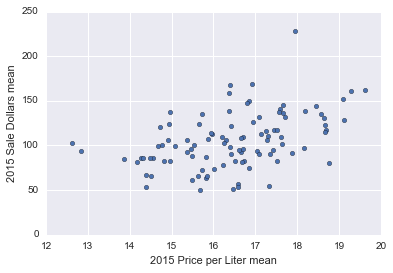

In [590]:
sales2015.plot(kind='scatter', x='2015 Price per Liter mean', y='2015 Sale Dollars mean')
# plt.show()
# sns.regplot(x="2015 Price per Liter mean", y='2015 Sale Dollars mean', data=sales2015)

In [591]:
# Change dates to weeks
liquor_df2['Date'] = map(lambda x:x.week, liquor_df2['Date'])

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


Locations with a high Price/Liter should technically have a higher sale. As we can see there is a trend, but it is not as dramatic as expected.

Model fit: 0.195520451198
0.0203852532051 14.3076302977


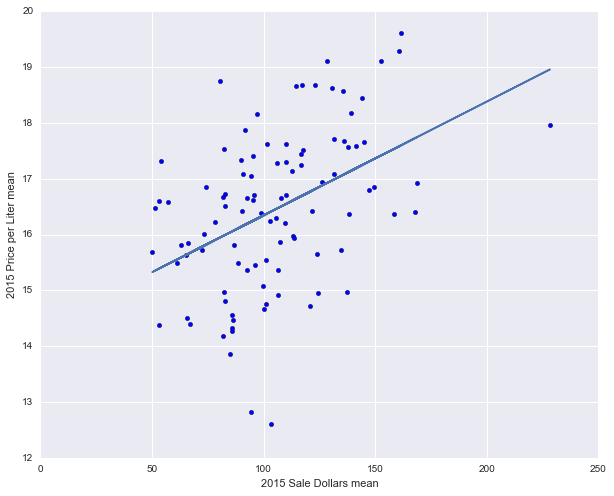

In [606]:
# Regression on Price/Liter and Sale Dollars. 

fig = plt.figure(figsize=(10,8))

lm = linear_model.LinearRegression()
X = sales2015[["2015 Sale Dollars mean"]]
y = sales2015["2015 Price per Liter mean"]
lm.fit(X, y)
predictions = lm.predict(X)
print "Model fit:", lm.score(X, y)
print lm.coef_[0], lm.intercept_

plt.scatter(X, y)
plt.plot(X, predictions)
plt.xlabel("2015 Sale Dollars mean")
plt.ylabel("2015 Price per Liter mean")
plt.show()

In [594]:
sales_2015 = liquor_df2[['County Number', 'Date', 'Sale Dollars','Volume Sold Liters']]

sales_2015 = sales_2015.groupby(['County Number', 'Date']).agg({'Sale Dollars': [np.mean, np.sum],
                                                               'Volume Sold Liters': [np.mean, np.sum]})

sales_2015.columns = [''.join(col)for col in sales_2015.columns.values]


sales_2015 = sales_2015.reset_index()

In [597]:
sales_2015.head(2)

,County Number,Date,Volume Sold Litersmean,Volume Sold Literssum,Sale Dollarsmean,Sale Dollarssum
0,1,1,5.903846,76.75,85.989231,1117.86
1,1,2,6.777143,142.32,92.305714,1938.42


Model fit: 0.851336402325


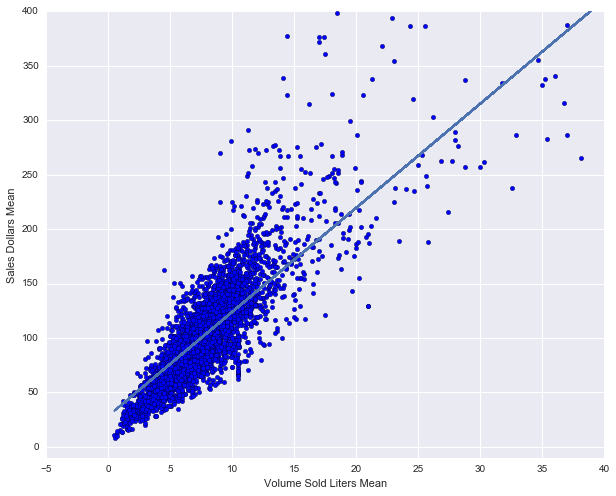

In [608]:
fig = plt.figure(figsize=(10,8))
lm = linear_model.LinearRegression()

X = sales_2015["Volume Sold Litersmean"]
y = sales_2015["Sale Dollarsmean"]

X = X.reshape(len(X),1)
y = y.reshape(len(y),1)

lm.fit(X, y)
predictions = lm.predict(X)
plt.scatter(X, y)
plt.plot(X, predictions)
plt.xlabel('Volume Sold Liters Mean')
plt.ylabel('Sales Dollars Mean')
plt.xlim(-5,40)
plt.ylim(-10,400)

print "Model fit:", lm.score(X, y)